In [ ]:
#Mount the Google drive which contains our dataset
 
from google.colab import drive          
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#import all the needed libraries
import mailbox
import nltk
%matplotlib inline
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas
import sklearn
import pickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
# from sklearn.grid_search import GridSearchCV
# from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
# from sklearn.learning_curve import learning_curve
from sklearn.model_selection import train_test_split
 
#import metrics libraries
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [ ]:
# #function to get email text from email body
# def getmailtext(message): #getting plain text 'email body'
#     body = None
#     #check if mbox email message has multiple parts
#     if message.is_multipart():
#         for part in message.walk():
#             if part.is_multipart():
#                 for subpart in part.walk():
#                     if subpart.get_content_type() == 'text/plain':
#                         body = subpart.get_payload(decode=True)
#             elif part.get_content_type() == 'text/plain':
#                 body = part.get_payload(decode=True)
#     #if message only has a single part            
#     elif message.get_content_type() == 'text/plain':
#         body = message.get_payload(decode=True)
#     #return mail text which concatenates both mail subject and body
#     mailtext=str(message['subject'])+" "+str(body)
#     return mailtext

In [ ]:
# #read spam mbox email file
# mbox = mailbox.mbox('/content/drive/MyDrive/Spam dataset/Spam.mbox')

# mlist_spam = []
# #create list which contains mail text for each spam email message
# for message in mbox:
#     mlist_spam.append(getmailtext(message))
#     #break
# #read ham mbox email file
# mbox_ham = mailbox.mbox('/content/drive/MyDrive/Spam dataset/Ham.mbox')

# mlist_ham = []
# count=0
# #create list which contains mail text for each ham email message
# for message in mbox_ham:
    
#     mlist_ham.append(getmailtext(message))
#     if count>601:
#         break
#     count+=1

In [ ]:
# #create 2 dataframes for ham spam mails which contain the following info-
# #Mail text, mail length, mail is ham/spam label
# import pandas as pd
# spam_df = pd.DataFrame(mlist_spam, columns=["message"])
# spam_df["label"] = "spam"

# spam_df['length'] = spam_df['message'].map(lambda text: len(text))
# print(spam_df.head())

# ham_df = pd.DataFrame(mlist_ham, columns=["message"])
# ham_df["label"] = "ham"

# ham_df['length'] = ham_df['message'].map(lambda text: len(text))
# print(ham_df.head())

                                             message label  length
0  Add a dose of Pharma to your portfolio. b'----...  spam    1591
1  =?utf-8?Q?GATE=20One=20year=20Preparation=20St...  spam    1056
2  =?utf-8?Q?GATE=20Exam=20Importance=2C=20Paper=...  spam    1127
3  Discover exciting new shores! b'Nippon India U...  spam    1970
4  PF Investment beyond 2.5 lakh taxed! Consider ...  spam    2562
                                             message label  length
0  =?UTF-8?Q?=F0=9F=93=A3Show_Her_Some_Appreciati...   ham    3380
1  Join The Lab - OnePlus 9 Series b'To view the ...   ham     571
2  Spring-Summer '21 Colour Trends b'Add them to ...   ham    3227
3  =?UTF-8?Q?Aapka_time_aagaya=E2=80=A6_ab_jaane_...   ham      75
4  =?utf-8?q?What_is_the_future_in_ECE=3F?= b'Har...   ham    5049


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Spam dataset/spam_ham_dataset.csv')
data.head()
# len(data['text'][0])

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [ ]:
data.rename(columns = {'text':'message'}, inplace = True)
data['length'] = data['message'].map(lambda text: len(text))
data=data.drop(['Unnamed: 0'], axis=1)
data=data.drop(['label_num'], axis=1)

columns_titles = ["message","label","length"]
data=data.reindex(columns=columns_titles)
data.head()

,message,label,length
0,Subject: enron methanol ; meter # : 988291\r\n...,ham,327
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",ham,97
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",ham,2524
3,"Subject: photoshop , windows , office . cheap ...",spam,414
4,Subject: re : indian springs\r\nthis deal is t...,ham,336


In [ ]:
# type(ham_df['message'][0])

In [ ]:
# #merge and shuffle dataframes for ham/spam mails
# mail_df = pd.concat([spam_df,ham_df])
# from sklearn.utils import shuffle
# mail_df = shuffle(mail_df)
# len(mail_df)

In [ ]:
mail_train, mail_test, y_train, y_test = train_test_split(data['message'],data['label'],test_size=0.33, random_state=42)


In [ ]:
#for each word in the email text, get the base form of the word and return the list of base words
def split_into_lemmas(message):
    message = message.lower()
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

In [ ]:
#function to apply the count vectorizer(BOW) and TF-IDF transforms to a set of input features
def features_transform(mail):
    #get the bag of words for the mail text
    bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(mail_train)
    #print(len(bow_transformer.vocabulary_))
    messages_bow = bow_transformer.transform(mail)
    #print sparsity value
    print('sparse matrix shape:', messages_bow.shape)
    print('number of non-zeros:', messages_bow.nnz) 
    print('sparsity: %.2f%%' % (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1])))
    #apply the TF-IDF transform to the output of BOW
    tfidf_transformer = TfidfTransformer().fit(messages_bow)
    messages_tfidf = tfidf_transformer.transform(messages_bow)
    #print(messages_tfidf.shape)
    #return result of transforms
    return messages_tfidf

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
train_features=features_transform(mail_train)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
sparse matrix shape: (3464, 38830)
number of non-zeros: 318764
sparsity: 0.24%


In [ ]:
#function which takes in y test value and y predicted value and prints the associated model performance metrics
def model_assessment(y_test,predicted_class):
    print('confusion matrix')
    print(confusion_matrix(y_test,predicted_class))
    print('accuracy')
    print(accuracy_score(y_test,predicted_class))
    print('precision')
    print(precision_score(y_test,predicted_class,pos_label='spam'))
    print('recall')
    print(recall_score(y_test,predicted_class,pos_label='spam'))
    print('f-Score')
    print(f1_score(y_test,predicted_class,pos_label='spam'))
    print('AUC')
    print(roc_auc_score(np.where(y_test=='spam',1,0),np.where(predicted_class=='spam',1,0)))
    plt.matshow(confusion_matrix(y_test, predicted_class), cmap=plt.cm.binary, interpolation='nearest')
    plt.title('confusion matrix')
    plt.colorbar()
    plt.ylabel('expected label')
    plt.xlabel('predicted label')

In [ ]:

from sklearn.ensemble import RandomForestClassifier

In [ ]:
#create and fit model
model_rf=RandomForestClassifier(n_estimators=20,criterion='entropy')

In [ ]:
model_rf.fit(train_features,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
email="Dear friends, Kalaben Acharya and I just returned from Kazakhstan.  I was invited by their President, Nursultan Nazarbayev, to attend their 6th Congress of World and Traditional Religions, and invited to speak on behalf of Hinduism, on we could make the world can be made more safe and secure. My father, Dr. Shantilal Somaiya had done much to foster inter faith understanding, and had been recognised in Kazakhstan (I have written more about that in a past letter here: https://www.somaiya.edu/oop/en/view-communications-page/37). I would like to share with you, the text of my speech, below. His Excellency Mr. Nursultan Nazarbayev, President of Kazakhstan. His Excellency Kassym-Jomart Tokayev, Leaders and Representatives of World and Traditional Religions. The word secure, is derived from Latin, and means ‘se’ -  without, and ‘cura’, care.  Meaning ‘without care’.  Without worry.  Without fear.  How do we help create a world where we all feel secure, free from fear and threats, and one in which we feel free to dream, hope and pursue our dreams."
email=[email]
predict_features=features_transform(email)
predicted_class_rf=model_rf.predict(predict_features)
print(predicted_class_rf)

sparse matrix shape: (1, 38830)
number of non-zeros: 90
sparsity: 0.23%
['ham']


In [ ]:
#run model on test and print metrics
test_features=features_transform(mail_test)
predicted_class_rf=model_rf.predict(test_features)

sparse matrix shape: (1707, 38830)
number of non-zeros: 143193
sparsity: 0.22%


confusion matrix
[[1222   24]
 [  46  415]]
accuracy
0.9589923842999414
precision
0.9453302961275627
recall
0.9002169197396963
f-Score
0.9222222222222223
AUC
0.9404776412502655


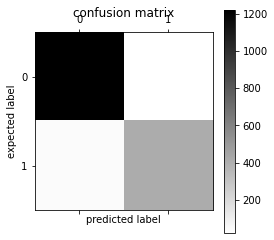

In [ ]:
model_assessment(y_test,predicted_class_rf)

In [ ]:
pickle.dump(model_rf, open('spamdetection.pkl','wb'))
spamdetection= pickle.load(open('spamdetection.pkl','rb'))